# Introduction

In this notebook we demonstrate the solution of simple linear transport equations such as

$$
\begin{align}
    -\epsilon \Delta u + b \cdot u &= f \qquad x \in \Omega \\
    u &= 0 \qquad x \in \partial \Omega
\end{align}
$$

where $\epsilon > 0$ is a (small) parameter, $b$ a given vector field and $f$ a given 
function. For this problem to be well posed it is required that $\nabla \cdot b = 0$.

There are two operators, the diffusion operator $-\epsilon \Delta$ which acts to smooth
out the source proportionally to $\epsilon$, and the transport operator 
$b \cdot \nabla u$ which acts to transport infinitesimal volumes of $u$ in the direction

In [1]:
import tenfem
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from matplotlib.collections import LineCollection

tf_dtype = tf.float32

In [2]:
mesh = tenfem.mesh.examples.circle(0.1, dtype=tf_dtype)
mesh = tenfem.mesh.triangle.convert_linear_to_quadratic(mesh)
mesh.add_matplotlib_tri()

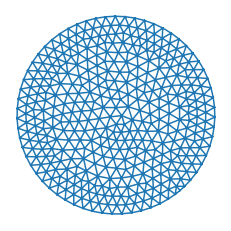

In [3]:
fig, ax = plt.subplots()
ax.triplot(mesh._triang)
ax.set_aspect('equal'); ax.axis('off')
plt.show()

In [4]:
element = tenfem.reference_elements.TriangleElement(degree=2, dtype=tf_dtype)

In [5]:
diff_coeff = 0.1*tf.ones([mesh.n_elements, element.element_dim])
tvf = tf.ones([mesh.n_elements, element.element_dim, 2])
source = tf.ones([mesh.n_elements, element.element_dim])

In [6]:
local_stiffness_mat = tenfem.fem.assemble_local_stiffness_matrix(diff_coeff,
                                                                 mesh,
                                                                 element)

In [7]:
local_convection_mat = tenfem.fem.assemble_local_convection_matrix(
    tvf, mesh, element)

In [8]:
source = tenfem.fem.assemble_local_load_vector(source, mesh, element)

In [9]:
local_bilinear_form = local_stiffness_mat + local_convection_mat

A = tenfem.fem.scatter_matrix_to_global(local_bilinear_form[tf.newaxis, ...], 
                                        mesh.elements[tf.newaxis, ...], 
                                        mesh.n_nodes)

b = tenfem.fem.scatter_vector_to_global(source[tf.newaxis, ...],
                                        mesh.elements[tf.newaxis, ...],
                                        mesh.n_nodes)

In [10]:
_, _, _, node_types = mesh.get_tensor_repr()
u = tenfem.fem.solve_dirichlet_form_linear_system(A[0], b[0], node_types, None)

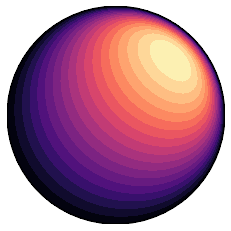

In [11]:
mtri = Triangulation(*mesh.nodes.numpy().T)

fig, ax = plt.subplots()

ax.tricontourf(mtri, u[:, 0], levels=20, cmap='magma')
ax.set_aspect('equal'); ax.axis('off')

ax.add_collection(
    LineCollection(tf.gather(mesh.nodes, mesh.boundary_elements), colors='k', label='$\partial \Omega$'))

plt.show()